In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Import all required libraries and dependencies


In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from nltk.tokenize import word_tokenize
from nltk import pos_tag
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from collections import defaultdict
from nltk.corpus import wordnet as wn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection, naive_bayes, svm
from sklearn.metrics import accuracy_score

import pickle
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
import tensorflow as tf
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from  tensorflow.keras.preprocessing import sequence

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [ ]:
np.random.seed(123) #random seed for consistency

# Load dataset

In [ ]:
data= pd.read_csv("/content/drive/MyDrive/AML coursework/Amazon_review.csv")

In [ ]:
data.head()

,review_id,text,verified,review_score,product_category
0,product_review_000000,Works great!. A Decent Condenser Mic,False,5.0,musical_instruments
1,product_review_000001,All these other posts about DRM this and DRM t...,False,1.0,video_games
2,product_review_000002,Great looking strings on my black classical gu...,True,5.0,musical_instruments
3,product_review_000003,I know people rant and rave about this game li...,True,2.0,video_games
4,product_review_000004,these things are great! just takes some time t...,True,5.0,video_games


# Remove empty text reviews

In [ ]:
data = data[~data['text'].isna()]

# Seperate data for rating and category prediction

Sperate train data and taking data with no label for example

## For Review rating


In [ ]:
review_data = data[['text','review_score']]
print(review_data.head())


review_train_data = review_data[review_data['review_score']!=-1.]
review_example_data = review_data[review_data['review_score']==-1.]
print("Number of training data ",review_train_data.shape[0])
print("Number of data for example ",review_example_data.shape[0])

                                                text  review_score
0               Works great!. A Decent Condenser Mic           5.0
1  All these other posts about DRM this and DRM t...           1.0
2  Great looking strings on my black classical gu...           5.0
3  I know people rant and rave about this game li...           2.0
4  these things are great! just takes some time t...           5.0
Number of training data  31997
Number of data for example  907


In [ ]:
r_texts_train = review_train_data['text'].values
r_texts_example = review_example_data['text'].values
r_labels_train = review_train_data['review_score'].values

In [ ]:
print("Labels : ",set(r_labels_train))

Labels :  {1.0, 2.0, 3.0, 4.0, 5.0}


## For Product Category


In [ ]:
product_data = data[['text','product_category']]
print(product_data.head())

product_train_data = product_data[~product_data['product_category'].isna()]
product_example_data = product_data[product_data['product_category'].isna()]
print("Number of training data ",product_train_data.shape[0])
print("Number of data for example ",product_example_data.shape[0])

                                                text     product_category
0               Works great!. A Decent Condenser Mic  musical_instruments
1  All these other posts about DRM this and DRM t...          video_games
2  Great looking strings on my black classical gu...  musical_instruments
3  I know people rant and rave about this game li...          video_games
4  these things are great! just takes some time t...          video_games
Number of training data  31998
Number of data for example  906


In [ ]:
p_texts_train = product_train_data['text'].values
p_texts_example = product_example_data['text'].values
p_labels_train = product_train_data['product_category'].values

In [ ]:
p_texts_train.shape,p_labels_train.shape

((31998,), (31998,))

In [ ]:
print("Labels : ",set(p_labels_train))

Labels :  {'video_games', 'musical_instruments'}


# Preprocess text
- Convert text to lowercase
- Tokenize sentences to words
- Find parts of speech tag of each word in the sentence
- Lemmatize each word with respect to its POS tag



In [ ]:
from tqdm import tqdm
def preprocess_text(text_data):

  data = [x.lower() for x in text_data]
  data = [word_tokenize(entry) for entry in data]

  tag_map = defaultdict(lambda : wn.NOUN)
  tag_map['J'] = wn.ADJ
  tag_map['V'] = wn.VERB
  tag_map['R'] = wn.ADV
  for index,entry in tqdm(enumerate(data),desc = "Processing text"):
    final_words = []
    word_lemmatized = WordNetLemmatizer()
    for word, tag in pos_tag(entry):
      if word not in stopwords.words('english') and word.isalpha():
        word_final = word_lemmatized.lemmatize(word,tag_map[tag[0]])
        final_words.append(word_final)
    data[index] = final_words
  data = [" ".join(sentence) for sentence in data]
  return data


In [ ]:
product_X_train_processed = preprocess_text(p_texts_train)
review_X_train_processed = preprocess_text(r_texts_train)

Processing text: 31998it [14:23, 37.07it/s]
Processing text: 31997it [14:09, 37.68it/s]


In [ ]:
pickle.dump(review_X_train_processed,open("/content/review_X_train_processed",'wb'))
pickle.dump(product_X_train_processed,open("/content/product_X_train_processed",'wb'))

In [ ]:
review_X_train_processed = pickle.load(open("/content/review_X_train_processed",'rb'))
product_X_train_processed = pickle.load(open("/content/product_X_train_processed",'rb'))

# Perform EDA


[Text(0.5, 1.0, 'Count of Reviews grouped by Score')]

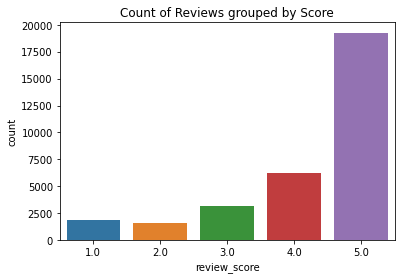

In [ ]:
review_count = review_data[review_data['review_score']!=-1.][['review_score']].value_counts().reset_index().rename(columns={0:'count'})
sns.barplot(x='review_score',y='count',data=review_count).set(title="Count of Reviews grouped by Score")

[Text(0.5, 1.0, 'Count of Products grouped by Category')]

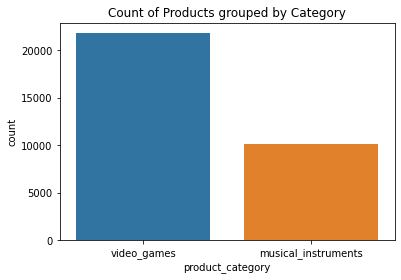

In [ ]:
product_count = product_data[['product_category']].value_counts().reset_index().rename(columns={0:'count'})
sns.barplot(x='product_category',y='count',data=product_count).set(title="Count of Products grouped by Category")

### The following plot shows there is equal distribution of video_game  and musical instrument  for each rating.

In [ ]:
#subplot by group
non_empty_data = data[~data['product_category'].isna()]
video_game_review_count = non_empty_data[non_empty_data['product_category']=='video_games']
video_game_review_count = video_game_review_count[['review_score']].value_counts().reset_index().rename(columns={0:'count'})

musical_instruments_review_count = non_empty_data[non_empty_data['product_category']=='musical_instruments']
musical_instruments_review_count = musical_instruments_review_count[['review_score']].value_counts().reset_index().rename(columns={0:'count'})

[Text(0.5, 1.0, 'Scores of Video Game Reviews')]

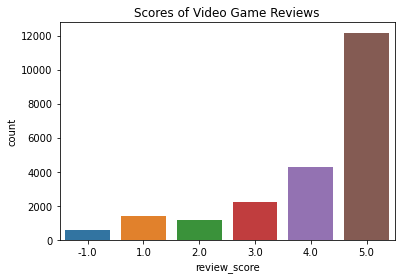

In [ ]:
sns.barplot(x='review_score',y='count',data=video_game_review_count).set(title='Scores of Video Game Reviews')

[Text(0.5, 1.0, 'Scores of Musical instrument Reviews')]

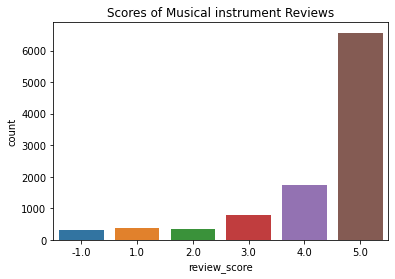

In [ ]:
sns.barplot(x='review_score',y='count',data=musical_instruments_review_count).set(title='Scores of Musical instrument Reviews')

# TFID Vectorization
Convert text into finite length vectors Term frequency — Inverse document frequency (TFIDF) is based on the Bag of Words (BoW) model, which contains insights about the less relevant and more relevant words in a document.

## Term Frequency (TF)
It is a measure of the frequency of a word (w) in a document (d). TF is defined as the ratio of a word’s occurrence in a document to the total number of words in a document.

## Inverse Document Frequency (IDF)
It is the measure of the importance of a word. Term frequency (TF) does not consider the importance of words. Some words such as’ of’, ‘and’, etc. can be most frequently present but are of little significance. IDF provides weightage to each word based on its frequency in the corpus D.

In [ ]:
#TFIDF vecotrization
Tfidf_vect = TfidfVectorizer(max_features=5000,lowercase=False)
Tfidf_vect.fit(product_X_train_processed)
review_X_train_vec = Tfidf_vect.transform(review_X_train_processed)
product_X_train_vec = Tfidf_vect.transform(product_X_train_processed)

# Encode Labels into vectors


In [ ]:
# encode review labels
p_le = LabelEncoder()

product_Y_train_vec = p_le.fit_transform(p_labels_train)
r_le = LabelEncoder()
review_Y_train_vec = r_le.fit_transform(r_labels_train)

In [ ]:
product_X_train_vec.shape

(31997, 5000)

In [ ]:
p_labels_train.shape

(31998,)

# Train Random forest for Product Category

In [ ]:
#random forest
from sklearn.ensemble import RandomForestClassifier
#train test split
prod_Train_X, prod_Val_X, prod_Train_Y, prod_Val_Y = model_selection.train_test_split(product_X_train_vec,product_Y_train_vec,test_size=0.2)
rfc = RandomForestClassifier(n_estimators=10)
rfc.fit(prod_Train_X,prod_Train_Y)

RandomForestClassifier(n_estimators=10)

# Test Product Category

In [ ]:
y_hat = rfc.predict(prod_Val_X)

from sklearn.metrics import confusion_matrix,accuracy_score,classification_report

y_actu = pd.Series(prod_Val_Y,name='Actual')
acc = accuracy_score(prod_Val_Y,y_hat,normalize=True)
print("Model accuray : %.2f"%acc)
print(classification_report(prod_Val_Y,y_hat))

Model accuray : 0.91
              precision    recall  f1-score   support

           0       0.86      0.85      0.86      2073
           1       0.93      0.94      0.93      4327

    accuracy                           0.91      6400
   macro avg       0.90      0.89      0.90      6400
weighted avg       0.91      0.91      0.91      6400



# Hyper parameter tuning for product category classification




In [ ]:
param_grid = {
    'n_estimators': [10,20, 30],
    'criterion' :['gini', 'entropy']
}

In [ ]:
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(prod_Train_X, prod_Train_Y)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'n_estimators': [10, 20, 30]})

In [ ]:
CV_rfc.best_estimator_.criterion

RandomForestClassifier(criterion='entropy', n_estimators=20)

In [ ]:
print(f"Hyper parameters of best model: \n criterion: {CV_rfc.best_estimator_.criterion} \n n_estimators: {CV_rfc.best_estimator_.n_estimators} ",)

Hyper parameters of best model: 
 criterion: entropy 
 n_estimators: 20 


In [ ]:
y_hat = CV_rfc.best_estimator_.predict(prod_Val_X)

y_actu = pd.Series(prod_Val_Y,name='Actual')
acc = accuracy_score(prod_Val_Y,y_hat,normalize=True)
print("Model accuray of best model: %.2f"%acc)
print(classification_report(prod_Val_Y,y_hat))

Model accuray of best model: 0.98
              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2073
           1       0.98      0.98      0.98      4327

    accuracy                           0.98      6400
   macro avg       0.97      0.97      0.97      6400
weighted avg       0.98      0.98      0.98      6400



In [ ]:
p_texts_example_vec = Tfidf_vect.transform(np.random.choice(p_texts_example,10,replace=False))
y_hat = CV_rfc.best_estimator_.predict(p_texts_example_vec)

for x,y in zip(p_texts_example,y_hat):
  print(x,p_le.inverse_transform([y]))
  print("-------------------------")

This does not expand dong.  ['musical_instruments']
-------------------------
It frequently happens when a game or a movie comes out that everyone seems to love yet nobody even bothers to go see it. Sometimes they have the good sense to know when something is awful so they avoid but then on other occasions they don't support it enough even though the general attitude is how incredible it was. When Okami was coming out for the PS2, it became one of those anticipated titles thanks to its unique and utterly beautiful visual style but despite the acclaim and awards, it wasn't a success and the studio, Clover Studios, had to close down. But fans kept speculating that the unique gameplay involving the brush could work well on the Wii or DS and pretty soon a Wii-port was announced. With some enhances features, the game is just as good on any system.

Story: The people of Kamiki Village used to live in fear of the 8-headed demon Orochi, who demanded a sacrifice from one of the village maidens 

# Training Review Rating prediction


In [ ]:
from sklearn.ensemble import RandomForestRegressor
rev_Train_X, rev_Val_X, rev_Train_Y,rev_Val_Y = model_selection.train_test_split(review_X_train_vec,review_Y_train_vec,test_size=0.2)
rfr = RandomForestRegressor(n_estimators=10)
rfr.fit(rev_Train_X,rev_Train_Y)

RandomForestRegressor(n_estimators=10)

# Testing Review Rating prediction


In [ ]:
y_hat = rfr.predict(rev_Val_X)
y_hat  = np.array([round(y) for y in y_hat])


y_actu = pd.Series(rev_Val_Y,name='Actual')
acc = accuracy_score(rev_Val_Y,y_hat,normalize=True)
print("Model accuray : %.2f"%acc)

Model accuray : 0.57


In [ ]:
r_texts_example_vec = Tfidf_vect.transform(np.random.choice(p_texts_example,10,replace=False))
y_hat = rfr.predict(r_texts_example_vec)

for x,y in zip(r_texts_example,y_hat):
  print(x,r_le.inverse_transform([round(y)]))
  print("-------------------------")

terrific.  [5.]
-------------------------
Very versatile. Now I can bring twelve pedals anywhere. So convenient. Looks like eyecandy too especially when colorful pedals are setup on it. I use the right combination of Boss pedals and play guitars with high quality humbucking pickups like EMG, Seymour Duncan, and DiMarzio. The noise is very minimal when pausing during a performance. Just avoid turning the compressor pedal's level and sustain to the maximum. Same with the distortion's level, gain or distortion level knob. With the right order of the pedals, the right settings, and the right pickups, and also the right placement of the pedalboard away from other electronic equipment that could generate noise, are some of the good ways to get a great sound from a big chain of pedals. A noise suppressor pedal may even be not necessary in the chain but for sure it would clean up all those remaining hiss or hum if included. The pedalboard's power supply works very well with all twelve pedals t

# Preprocessig for LSTM Model

- Tokenize sentences to words
- Convert text to numercial values
- Pad sequences for consistent input to model



In [ ]:

voc_size = 5000
max_len = 128
tok = Tokenizer(num_words=voc_size)
tok.fit_on_texts(review_X_train_processed)
sequences = tok.texts_to_sequences(product_X_train_processed)
prod_sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)
sequences = tok.texts_to_sequences(review_X_train_processed)
rev_sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [ ]:
seq_lens = pd.DataFrame([len(s) for s in sequences])
seq_lens.plot(kind='box').set(title="Visualizing distribution of length of sentences")

# One hot encode labels

In [ ]:
p_le = LabelEncoder()
p_encoded_labels = p_le.fit_transform(p_labels_train)
p_labels_vec = to_categorical(p_encoded_labels)
r_le = LabelEncoder()
r_encoded_labels = r_le.fit_transform(r_labels_train)
r_labels_vec = to_categorical(r_encoded_labels)

# Creating LSTM model

In [ ]:

def model(input_shape,n_classes,loss='binary_crossentropy'):


  model=tf.keras.Sequential()

  model.add(tf.keras.layers.Embedding(voc_size,45,input_length=128))

  model.add(tf.compat.v1.keras.layers.CuDNNLSTM(128,input_shape=(input_shape),return_sequences=True))

  model.add(tf.keras.layers.Dropout(0.2))

  model.add(tf.compat.v1.keras.layers.CuDNNLSTM(128))

  model.add(tf.keras.layers.Dropout(0.2))

  model.add(tf.keras.layers.Dense(32,activation='sigmoid'))

  model.add(tf.keras.layers.Dropout(0.2))

  model.add(tf.keras.layers.Dense(n_classes,activation='softmax'))

  model.compile(loss=loss,optimizer='adam',metrics=['accuracy'])

  return model

In [ ]:
prod_model = model(prod_sequences_matrix.shape,p_labels_vec.shape[1])
prod_model.summary()

In [ ]:
prod_model = model(prod_sequences_matrix.shape,p_labels_vec.shape[1])
prod_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_7 (Embedding)     (None, 128, 45)           225000    
                                                                 
 cu_dnnlstm_7 (CuDNNLSTM)    (None, 128, 128)          89600     
                                                                 
 dropout_9 (Dropout)         (None, 128, 128)          0         
                                                                 
 cu_dnnlstm_8 (CuDNNLSTM)    (None, 128)               132096    
                                                                 
 dropout_10 (Dropout)        (None, 128)               0         
                                                                 
 dense_6 (Dense)             (None, 32)                4128      
                                                                 
 dropout_11 (Dropout)        (None, 32)               

In [ ]:
p_labels_vec.shape

(31998, 2)

In [ ]:
r_labels_vec.shape

(31997, 5)

In [ ]:
rev_model = model(rev_sequences_matrix.shape,r_labels_vec.shape[1],loss='categorical_crossentropy')
rev_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 128, 45)           225000    
                                                                 
 cu_dnnlstm_11 (CuDNNLSTM)   (None, 128, 128)          89600     
                                                                 
 dropout_15 (Dropout)        (None, 128, 128)          0         
                                                                 
 cu_dnnlstm_12 (CuDNNLSTM)   (None, 128)               132096    
                                                                 
 dropout_16 (Dropout)        (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 32)                4128      
                                                                 
 dropout_17 (Dropout)        (None, 32)               

In [ ]:
from sklearn.model_selection import train_test_split
p_X_train, p_X_test, p_y_train, p_y_test = train_test_split(prod_sequences_matrix, p_labels_vec, test_size=0.1, random_state=42,stratify=p_labels_vec)
r_X_train, r_X_test, r_y_train, r_y_test = train_test_split(rev_sequences_matrix, r_labels_vec, test_size=0.1, random_state=42,stratify=r_labels_vec)

In [ ]:
prod_model.fit(p_X_train,p_y_train,validation_data=(p_X_test,p_y_test),epochs=10,batch_size=128)

Epoch 1/10
225/225 [==============================] - 45s 69ms/step - loss: 0.5554 - accuracy: 0.7232 - val_loss: 0.2684 - val_accuracy: 0.8900
Epoch 2/10
225/225 [==============================] - 15s 65ms/step - loss: 0.2244 - accuracy: 0.9137 - val_loss: 0.1746 - val_accuracy: 0.9272
Epoch 3/10
225/225 [==============================] - 15s 65ms/step - loss: 0.1509 - accuracy: 0.9399 - val_loss: 0.1478 - val_accuracy: 0.9378
Epoch 4/10
225/225 [==============================] - 15s 64ms/step - loss: 0.1275 - accuracy: 0.9472 - val_loss: 0.1409 - val_accuracy: 0.9428
Epoch 5/10
225/225 [==============================] - 14s 64ms/step - loss: 0.1289 - accuracy: 0.9494 - val_loss: 0.1533 - val_accuracy: 0.9381
Epoch 6/10
225/225 [==============================] - 15s 65ms/step - loss: 0.1052 - accuracy: 0.9554 - val_loss: 0.1493 - val_accuracy: 0.9397
Epoch 7/10
225/225 [==============================] - 15s 65ms/step - loss: 0.0988 - accuracy: 0.9575 - val_loss: 0.1567 - val_accuracy:

In [ ]:
rev_model.fit(r_X_train,r_y_train,validation_data=(r_X_test,r_y_test),epochs=20,batch_size=128)

Epoch 1/20
225/225 [==============================] - 18s 68ms/step - loss: 1.0722 - accuracy: 0.6050 - val_loss: 0.9467 - val_accuracy: 0.6294
Epoch 2/20
225/225 [==============================] - 15s 65ms/step - loss: 0.9096 - accuracy: 0.6437 - val_loss: 0.9209 - val_accuracy: 0.6400
Epoch 3/20
225/225 [==============================] - 14s 64ms/step - loss: 0.8667 - accuracy: 0.6555 - val_loss: 0.9057 - val_accuracy: 0.6450
Epoch 4/20
225/225 [==============================] - 14s 64ms/step - loss: 0.8292 - accuracy: 0.6733 - val_loss: 0.8878 - val_accuracy: 0.6619
Epoch 5/20
225/225 [==============================] - 15s 66ms/step - loss: 0.7743 - accuracy: 0.6972 - val_loss: 0.8917 - val_accuracy: 0.6609
Epoch 6/20
225/225 [==============================] - 14s 64ms/step - loss: 0.7347 - accuracy: 0.7171 - val_loss: 0.8975 - val_accuracy: 0.6684
Epoch 7/20
225/225 [==============================] - 15s 66ms/step - loss: 0.6934 - accuracy: 0.7357 - val_loss: 0.9340 - val_accuracy:

In [ ]:
product_example_data = product_data[~product_data['product_category'].isna()]
prod_examples =  product_example_data['text'].sample(10,random_state=45).to_numpy()
prod_examples_processed = preprocess_text(prod_examples)
prod_examples_seq = tok.texts_to_sequences(prod_examples_processed)
prod_examples_seq = sequence.pad_sequences(prod_examples_seq,maxlen=max_len)

Processing text: 10it [00:00, 10.53it/s]


In [ ]:
y_hat = prod_model.predict(prod_examples_seq)
for x,y in zip(prod_examples,y_hat):
  print(x,p_le.inverse_transform([np.argmax(y)]))
  print("-------------------------")

This controller the bittons had to be mashed so hard it hurt.... which isn't possible when playing something like the mario games. Didnt work ['video_games']
-------------------------
Quick Shipment, Excellent Product. Thank You ['musical_instruments']
-------------------------
Great story, great gameplay and tones of replay ability. it took me about two weeks to pass the hole campaign along with all the side quests. longest story driven game i have played.. lots of replay ability ['video_games']
-------------------------
they work pretty good so far. i have had no training on drums what so ever..im a guitar player  or keys.on ps3...the drums are the hardest to get use to because my left hand is not use to being used in this manor...but it works.they do what they are suppose to. im still working on learning to play..great set A+. drums ['musical_instruments']
-------------------------
Nice headsets and good audio quality, excellent and sturdy build and very comfortable.
The mic in a li

In [ ]:
review_example_data = review_data[review_data['review_score']==-1.]
review_examples = review_example_data['text'].sample(10,random_state=45).to_numpy()
# preproces
review_examples_processed = preprocess_text(review_examples)
# vectorize
review_examples_seq = tok.texts_to_sequences(review_examples_processed)
review_examples_seq = sequence.pad_sequences(review_examples_seq,maxlen=max_len)


Processing text: 10it [00:00, 10.53it/s]


In [ ]:
y_hat = rev_model.predict(review_examples_seq)
for x,y in zip(prod_examples,y_hat):
  print(x,r_le.inverse_transform([np.argmax(y)]))
  print("-------------------------")

This controller the bittons had to be mashed so hard it hurt.... which isn't possible when playing something like the mario games. Didnt work [5.]
-------------------------
Quick Shipment, Excellent Product. Thank You [5.]
-------------------------
Great story, great gameplay and tones of replay ability. it took me about two weeks to pass the hole campaign along with all the side quests. longest story driven game i have played.. lots of replay ability [5.]
-------------------------
they work pretty good so far. i have had no training on drums what so ever..im a guitar player  or keys.on ps3...the drums are the hardest to get use to because my left hand is not use to being used in this manor...but it works.they do what they are suppose to. im still working on learning to play..great set A+. drums [5.]
-------------------------
Nice headsets and good audio quality, excellent and sturdy build and very comfortable.
The mic in a little bit tricky but have an average volume and is bendable.
